# Comparison of two Megaline calling plans
### Author: Xia Cui 

### Introduction 

Telecom operator Megaline offers its clients two prepaid plans, **Surf** and **Ultimate**. This data analysis project aims to analyze Megaline clients' usage behavior and find out which of the plans is more profitable in order for the commercial department to adjust their advertising budget.

This preliminary analysis of the plans is based on a relatively small client selection: 500 Megaline clients, and their usage of the calling plans in 2018. The analysis will be looking at the clients' use of three services: call, message, and internet, and find out the distribution of the usage so as to understand the clients' needs. 

The comparison of the plan profits, together with an understanding of the consumer needs, will allow the company to decide which plan and what service to promote, and how best to promote them. 

The table of content below shows the six parts to the report. 

### Table of content 
#### [Part 1: Data importing](#importing)  
#### [Part 2: Data preprocessing](#preprocessing)  
#### [Part 3: Data transformation](#transformation)  
#### [Part 4: Exploratory data analysis](#eda)  
#### [Part 5: Hypothesis testing](#hypothesis)  
#### [Part 6: Findings and conclusions](#conclusion)  

In [89]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats as st
from IPython.display import display
import seaborn as sns
%matplotlib inline

### Part 1: Data importing

There are a total of 5 datasets for this project. Let's first download them and have a quick look at the information structure. 

In [90]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_internet.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_messages.csv')
plans = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_plans.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_users.csv')

Check the first 5 rows of each dataset and its general information. 

In [91]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [92]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [93]:
calls.shape

(137735, 4)

The **calls** dataset shows call id, user_id, the date the call was made, and the duration. It contains 137735 rows. The data type for the call_date column is object, which will need to be changed to date in the preprocessing stage. 

It needs to be noted that, the plan description states that each individual call is rounded up when calculating the cost: even if the call lasted just one second, it will be counted as one minute. 

In [94]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [95]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [96]:
internet.shape

(104825, 4)

The **internet** dataset includes the internet use id, user_id, the date the internet use occurred, and the data used. The session date will need to be changed to date data type. There also might be rows that have 0 value in mb_used, which we could consider removing as the next step. 

The plan description states that, for web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes. This will be taken into account when calculating the data cost for each user. 

In [97]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [98]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [99]:
messages.shape

(76051, 3)

The **messages** dataset contains 76051 rows and three columns: the message id, user id, and the date the message was sent. The message_date will need to be changed to date data type as well. 

In [100]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [101]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In the **plans** dataset, the Surf plan is row 0, and the Ultimate plan, row 1. It contains the information of what is included in the plan, the plan cost, and how to charge the user when messages, calls, and data included in the plan are used up. 

In [102]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [103]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [104]:
users.shape

(500, 8)

The **users** dataset includes information about the 500 Megaline users. reg_date is the date they are registered, and the churn_date is the date they stopped using the service. NaN in churn_date indicates the user is still using the plan at the time the data was collected. Both columns will need to be changed to the date data type. 

### Part 1 Summary 

After importing the 5 datasets and taking a look at their general information, we can tell that these are overall in pretty good condition to be further analyized. However, there are some small issues to be addressed, which are: 

- the date columns need to be changed to **date** data type
- call duration and data usage columns contain 0 values that we could consider removing 
- the *age* column in **users** could be changed to age groups for easy manipulation
- some additional columns based on existing information, such as month of the usage, will be needed. 

There might also be errors in the data which we haven't detected yet. In the next section, we will check the dataset one by one for errors and address the issues noted above.  

### Part 2: Data preprocessing 

<a id="preprocessing"></a>

**2.1 Check and prepare the calls dataset** 

In [105]:
calls.isnull().sum(axis = 0)

id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [106]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

In [107]:
len(calls['user_id']. unique())

481

Out of the 500 Megaline clients, 481 have records of making calls in this dataset. 

In [108]:
len(calls['call_date'].unique())

351

There are a total of 351 days on the record in this dataset. 

In [109]:
calls['duration'].describe()

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64

In [110]:
len(calls[calls['duration'] == 0]) / len(calls)

0.1948233927469416

The rows that have call duration as 0 represents almost 20 percent of the total data. These are calls that never happened. Given the purpose of this analysis is to find out which plan is more profitable, we are only interested in the calls that will go into the cost calculation. Therefore. These rows can be dropped. 

In [111]:
calls = calls.query('duration != 0').reset_index(drop = True)

In [112]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110901 entries, 0 to 110900
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         110901 non-null  object        
 1   user_id    110901 non-null  int64         
 2   call_date  110901 non-null  datetime64[ns]
 3   duration   110901 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.4+ MB


**2.2 Check and prepare the internet dataset**

In [113]:
internet.isnull().sum(axis = 0)

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [114]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = "%Y-%m-%d")

In [115]:
len(internet['session_date'].unique())

351

In [116]:
len(internet['user_id'].unique())

489

489 out of 500 Megaline users have used the internet service in 2018. 

In [117]:
internet['mb_used'].describe()

count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64

In [118]:
len(internet[internet['mb_used'] == 0]) / len(internet)

0.1311423801574052

The rows that have 0 data usage represents about 13% of the total data. Similar to the call dataset, the 0 value rows can be removed from the internet dataset. 

In [119]:
internet = internet.query('mb_used != 0').reset_index(drop = True)

In [120]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91078 entries, 0 to 91077
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            91078 non-null  object        
 1   user_id       91078 non-null  int64         
 2   session_date  91078 non-null  datetime64[ns]
 3   mb_used       91078 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.8+ MB


**2.3 Check and prepare the message dataset**

In [121]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

In [122]:
len(messages['user_id'].unique())

402

402 out of 500 Megaline clients have used the message service in 2018. It's interesting to note that almost 25% of the users didn't use the text message function at all. From Megaline's perspective, it would be helpful to know who those users are and adjust their promotion of calling plans to such sub group accordingly. We will come back to this later in the analysis. 

In [123]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


**2.4 Check and prepare the plans dataset**

In [124]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The plans dataset is easy. Nothing needs to be modified. 

**2.5 Check and prepare the users dataset**

In [125]:
users.isnull().sum(axis=0)

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

Out of 500 Megaline clients, there are 34 who have stopped using the plan. It would be interesting to see who these 34 people are and what their plans and usage are like. We'll keep this in mind for now. 

We can easily use pandas to_datetime function to convert the data type for the 'reg_date' column. For the 'churn_date' column, let's convert the 34 which have stopped the plan, and replace the NaN values in the rest of the rows with a empty string. 

In [126]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

In [127]:
users['churn_date'] = users['churn_date'].where(
    users['churn_date'].isna(), pd.to_datetime(users['churn_date'], format = '%Y-%m-%d'))

In [128]:
users['churn_date'] = users['churn_date'].fillna("")

In [129]:
users.isnull().sum(axis = 0)

user_id       0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64

In [130]:
users['city'].value_counts()

New York-Newark-Jersey City, NY-NJ-PA MSA          80
Los Angeles-Long Beach-Anaheim, CA MSA             29
Dallas-Fort Worth-Arlington, TX MSA                21
Chicago-Naperville-Elgin, IL-IN-WI MSA             19
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA    17
                                                   ..
Greensboro-High Point, NC MSA                       1
Oxnard-Thousand Oaks-Ventura, CA MSA                1
Cape Coral-Fort Myers, FL MSA                       1
Albany-Schenectady-Troy, NY MSA                     1
Raleigh-Cary, NC MSA                                1
Name: city, Length: 73, dtype: int64

There are a total of 73 cities on record in this dataset. Ideally, it would be more organized to have the state in a single column separate from the city column. However, for the purpose of this analysis, this information is not considered cruicial. Therefore, let's leave the information as it is. 

### Part 2 summary 

In this section, we checked through each dataset for error and changed the date column data type. The rows in calls and internet datasets which are 0 havev been removed. All datasets are neat and tidy now. In the next section: Data transformation, we will add some columns to the existing datasets to facilitate the follow up analysis.

### Part 3: Data transformation 

<a id="transformation"></a>

To further prepare the data for the follow up analysis, we will need to add a month column to the **calls**, **internet**, and **message** dataset so that we can calculate the montly usage. Given all the data were collected in 2018. The month column alone would be sufficient. 

In addition, given that for calls each individual call is rounded up to the minute, we will need to add a column to the **calls** dataset with the minute only. 

we will also need to add a 'age_group' column to the users dataset, and extract a reduced set of columns from it into a new dataset. 

Last, just out of interest, we will single out the 34 users who have terminated their service and have a look at them at a later stage. 

**3.1 Add a month column to each service usage dataset**

In [131]:
calls['call_month'] = pd.DatetimeIndex(calls['call_date']).month

In [132]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110901 entries, 0 to 110900
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          110901 non-null  object        
 1   user_id     110901 non-null  int64         
 2   call_date   110901 non-null  datetime64[ns]
 3   duration    110901 non-null  float64       
 4   call_month  110901 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.2+ MB


In [133]:
internet['session_month'] = pd.DatetimeIndex(internet['session_date']).month

In [134]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91078 entries, 0 to 91077
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             91078 non-null  object        
 1   user_id        91078 non-null  int64         
 2   session_date   91078 non-null  datetime64[ns]
 3   mb_used        91078 non-null  float64       
 4   session_month  91078 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.5+ MB


In [135]:
messages['message_month'] = pd.DatetimeIndex(messages['message_date']).month

In [136]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             76051 non-null  object        
 1   user_id        76051 non-null  int64         
 2   message_date   76051 non-null  datetime64[ns]
 3   message_month  76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


**3.2 Add a 'duration_minute' column to the calls dataset**

In [137]:
calls['duration_minute'] = calls['duration'].apply(np.ceil)

In [138]:
calls.head()

,id,user_id,call_date,duration,call_month,duration_minute
0,1000_93,1000,2018-12-27,8.52,12,9.0
1,1000_145,1000,2018-12-27,13.66,12,14.0
2,1000_247,1000,2018-12-27,14.48,12,15.0
3,1000_309,1000,2018-12-28,5.76,12,6.0
4,1000_380,1000,2018-12-30,4.22,12,5.0


**3.3 Add 'age_group' column to users dataset**

In [139]:
users['age'].describe()

count    500.000000
mean      45.486000
std       16.972269
min       18.000000
25%       30.000000
50%       46.000000
75%       61.000000
max       75.000000
Name: age, dtype: float64

Age as individual numbers may not be the most useful if we are to look for people's behavioural characteristics in using calling plans. Therefore let's convert these into age groups:  18 - 34, 35 - 44, 45 - 54, 55 - 64, above 65.

In [140]:
def age_group_func(age):
    if 18 <= age < 35:
        return '18-34'
    elif 35 <= age < 45:
        return '35-44'
    elif 45 <= age < 55:
        return '45-54'
    elif 55 <= age <= 65:
        return '55-65'
    else:
        return 'above 65'

In [141]:
users['age_group'] = users['age'].apply(age_group_func)

In [142]:
users['age_group'].value_counts()

18-34       164
45-54        92
55-65        89
above 65     81
35-44        74
Name: age_group, dtype: int64

Now we have five age groups, instead of 500 individual numbers. 

**3.4 Create a new user dataset containing a reduced set of columns**

In the **users** dataset, the most useful columns to the goals of our analysis are user_id, plan, age_group, and city. Therefore let's save these columns into a new dataset: users_new, and use this for our follow up analysis. 

In [143]:
users_new = users[['user_id', 'age_group', 'plan', 'city']]

In [144]:
users_new.head()

,user_id,age_group,plan,city
0,1000,45-54,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,18-34,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1002,35-44,surf,"Las Vegas-Henderson-Paradise, NV MSA"
3,1003,45-54,surf,"Tulsa, OK MSA"
4,1004,35-44,surf,"Seattle-Tacoma-Bellevue, WA MSA"


For the reduced dataset, plan is shown in either 'ultimate' or 'surf'. If the dataset were a lot large, we would have used code to represent these two values. However, give we only have 500 entries in this dataset, we won't create another reference table and let's keep the column as it is.

**3.5 Create a dataset of users who have terminated their plan**

In [145]:
users_previous = users[users['churn_date'] != '']

In [146]:
len(users_previous)

34

### Part 3 summary 

In this section, we added a month column to the **calls**, **internet**, and **message** dataset, a new duration column in minutes to **calls** dataset, an 'age_group' column to the users dataset, and extract a reduced set of columns from it into a new users dataset. Now the datasets are ready for the exploratory analysis next. 

### Part 4: Exploratory data analysis 

<a id="eda"></a>

In this section, we will first summarize the following for each Megaline user: 
- the number of calls made and minutes used per month
- the number of text messages sent per month
- the volume of data per month
- the monthly profit from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

From the information above, we'll then find the minutes, texts, and volume of data the users of each plan require per month and plot them in histograms. The mean, dispersion, and standard deviation of these will also be calculated. 


**4.1 The number of calls made and minutes used per month by user**

In [147]:
calls.head()

,id,user_id,call_date,duration,call_month,duration_minute
0,1000_93,1000,2018-12-27,8.52,12,9.0
1,1000_145,1000,2018-12-27,13.66,12,14.0
2,1000_247,1000,2018-12-27,14.48,12,15.0
3,1000_309,1000,2018-12-28,5.76,12,6.0
4,1000_380,1000,2018-12-30,4.22,12,5.0


Let's group the calls data by 'user_id' and 'call_month' and calculate the number of calls and total minutes each month. 

In [148]:
calls_user = calls.groupby(['user_id', 'call_month']).aggregate({
    'duration_minute' : ['count','sum']})

In [149]:
calls_user.columns = ['number_of_calls', 'total_minutes']

In [150]:
calls_user = calls_user.reset_index()
display(calls_user)

,user_id,call_month,number_of_calls,total_minutes
0,1000,12,16,124.0
1,1001,8,22,182.0
2,1001,9,38,315.0
3,1001,10,47,393.0
4,1001,11,49,426.0
...,...,...,...,...
2251,1498,12,32,339.0
2252,1499,9,35,346.0
2253,1499,10,41,385.0
2254,1499,11,39,308.0


Let's take a look at the summary statistics of the number of calls and the calling minutes each month by the users. 

In [151]:
calls_user[['number_of_calls', 'total_minutes']].describe()

,number_of_calls,total_minutes
count,2256.000000,2256.000000
mean,49.158245,436.324025
std,25.667968,231.711444
min,1.000000,2.000000
25%,32.000000,275.000000
50%,48.000000,429.000000
75%,64.000000,575.250000
max,167.000000,1510.000000


Let's make two plots showing their distribution. 

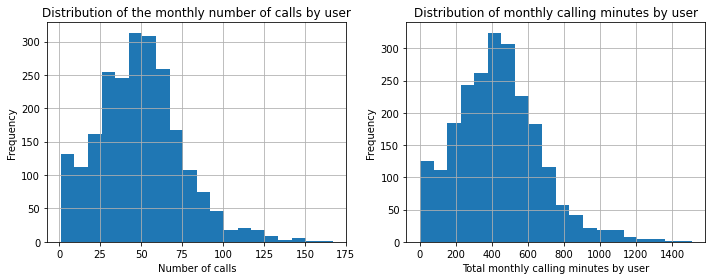

In [152]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
calls_user.hist('number_of_calls', bins = 20, grid = True, ax = ax1)
ax1.set_xlabel('Number of calls')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of the monthly number of calls by user')

calls_user.hist('total_minutes', bins = 20, grid = True, ax = ax2)
ax2.set_xlabel('Total monthly calling minutes by user')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of monthly calling minutes by user')

plt.tight_layout() 

Overall, the number of calls per month by user peaks around 50, and the monthly minutes peak around 500 minutes. 

**4.2 the number of text messages sent per month by user**

In [153]:
messages.head()

,id,user_id,message_date,message_month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [154]:
messages_user = messages.groupby(['user_id', 'message_month']).aggregate({'id' : 'count'})

In [155]:
messages_user.columns = ['total_messages']

In [156]:
messages_user = messages_user.reset_index()
display(messages_user)

,user_id,message_month,total_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


Let's take a look at the summary statistics of the total messsages. 

In [157]:
messages_user['total_messages'].describe()

count    1806.000000
mean       42.110188
std        33.122931
min         1.000000
25%        17.000000
50%        34.000000
75%        59.000000
max       266.000000
Name: total_messages, dtype: float64

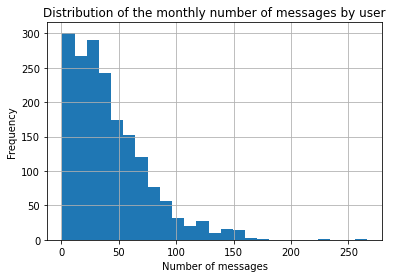

In [158]:
messages_user.hist('total_messages', bins = 25, grid = True, figsize = (6,4))
plt.xlabel('Number of messages')
plt.ylabel('Frequency')
plt.title('Distribution of the monthly number of messages by user')

plt.show() 

As shown above, there are some outliers on the right hand side. Majority of the numbers are below 50, which is below the message cap in the surf plan. 

**4.3 The volume of data per month by user**

As the plans description requires, we will round up the monthly mb_used to gb.

In [159]:
internet_user = internet.groupby(['user_id', 'session_month']).aggregate({'mb_used': 
                                                          lambda x: np.ceil(sum(x)/1024)})

In [160]:
internet_user.columns = ['gb_used']

In [161]:
internet_user = internet_user.reset_index()
display(internet_user)

,user_id,session_month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2272,1498,12,23.0
2273,1499,9,13.0
2274,1499,10,20.0
2275,1499,11,17.0


In [162]:
internet_user['gb_used'].describe()

count    2277.000000
mean       16.989021
std         7.693683
min         1.000000
25%        13.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_used, dtype: float64

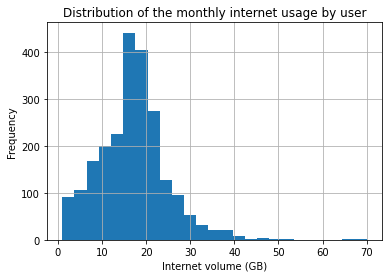

In [163]:
internet_user.hist('gb_used', bins = 25, grid = True, figsize = (6,4))
plt.xlabel('Internet volume (GB)')
plt.ylabel('Frequency')
plt.title('Distribution of the monthly internet usage by user')

plt.show() 

As shown above, the internet usage peaks between 15-20GB, which is above the surf plan cap, and below the ultimate plan cap. 

The numbers and graphs above give an overall picture of how the services are used. In a later section, we will have a look at the usage by plan. 

**4.4 Calculate the monthly profit from each user** 

To obtain this figure, we will need to subtract the free package limit from the total number of calls, text messages, and data, and then multiply the result by the calling plan value, and add the monthly charge depending on the calling plan. 

Let's first create two 'user_id' series that contain the surf and ultimate users' id respectively. 

In [164]:
surf_user_ids = users_new.query('plan == "surf"')['user_id']
ultimate_user_ids = users_new.query('plan == "ultimate"')['user_id']

In [165]:
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Let's define the functions to apply to the row of the above summary datasets to calculate the profit for each user each month in each service category. 

In [166]:
def monthly_call_profit(row):
    if row['user_id'] in surf_user_ids.values: 
        if row['total_minutes'] <= 500:
            return 0
        else: 
            profit = (row['total_minutes'] - 500) * 0.03
            return profit
    else: 
        if row['total_minutes'] <= 3000:
            return 0
        else: 
            profit = (row['total_minutes'] - 3000) * 0.01
            return profit

def monthly_message_profit(row):
    if row['user_id'] in surf_user_ids.values: 
        if row['total_messages'] <= 50:
            return 0
        else: 
            profit = (row['total_messages'] - 50) * 0.03
            return profit
    else: 
        if row['total_messages'] <= 1000:
            return 0
        else: 
            profit = (row['total_messages'] - 1000) * 0.01
            return profit


def monthly_internet_profit(row):
    if row['user_id'] in surf_user_ids.values: 
        if row['gb_used'] <= 15:
            return 0
        else: 
            profit = (row['gb_used'] - 15) * 10
            return profit
    else: 
        if row['gb_used'] <= 30:
            return 0
        else: 
            profit = (row['gb_used'] - 30) * 7
            return profit

Now, let's apply these functions. 

In [167]:
calls_user['calls_profit'] = calls_user.apply(monthly_call_profit, axis = 1)

In [168]:
messages_user['messages_profit'] = messages_user.apply(monthly_message_profit, axis = 1)

In [169]:
internet_user['internet_profit'] = internet_user.apply(monthly_internet_profit, axis = 1)

Let's double check if the functions have applied by filtering the data by user_ids and their usage and calculating the profits. 

In [170]:
calls_user[(calls_user['user_id'].isin(surf_user_ids)) & 
           (calls_user['total_minutes']< 500)]['calls_profit'].sum()

0.0

In [171]:
calls_user[(calls_user['user_id'].isin(surf_user_ids)) & 
           (calls_user['total_minutes'] > 500)]['calls_profit'].sum()

2900.25

In [172]:
messages_user[(messages_user['user_id'].isin(surf_user_ids)) & 
           (messages_user['total_messages']< 50)]['messages_profit'].sum()

0.0

In [173]:
messages_user[(messages_user['user_id'].isin(surf_user_ids)) & 
           (messages_user['total_messages'] > 50 )]['messages_profit'].sum()

330.93

In [174]:
internet_user[(internet_user['user_id'].isin(ultimate_user_ids)) & 
           (internet_user['gb_used']< 30)]['internet_profit'].sum()

0.0

In [175]:
internet_user[(internet_user['user_id'].isin(ultimate_user_ids)) & 
           (internet_user['gb_used']> 30)]['internet_profit'].sum()

1666.0

All look good! We can move on. 

What we have here in the 3 datasets are the profits from each user each month in three services. The profit from each user of two different plans will be the addup of the profits from all three plus the plan cost. To calculate this, we will need to merge the datasets first by user_id and month.

First, let's rename the month column in each dataset so they all have the same name. 

In [176]:
calls_user = calls_user.rename(columns = {'call_month': 'month'})

In [177]:
messages_user = messages_user.rename(columns = {'message_month' : 'month'})

In [178]:
internet_user = internet_user.rename(columns = {'session_month' : 'month'})

The three datasets are of different length and their 'user_id's do not exactly match. This is understandable because we might expect some users to use only one or 2 services from the provider instead of all three, and this can vary from month to month too. Therefore when merging the data, we will set 'how' as 'outer' so we do not lose any records. 

In [179]:
profits = calls_user.merge(messages_user, on = ['user_id', 'month'], 
                 how = 'outer').merge(internet_user, on = ['user_id', 'month'], how = 'outer')

The NaN value in this merged dataset happens because the user hasn't used that particular service in that month but has used other services. Therefore we can replace the NaN value with 0 for easy calculation. 

In [180]:
profits = profits.fillna(0)

In [181]:
profits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          2293 non-null   int64  
 1   month            2293 non-null   int64  
 2   number_of_calls  2293 non-null   float64
 3   total_minutes    2293 non-null   float64
 4   calls_profit     2293 non-null   float64
 5   total_messages   2293 non-null   float64
 6   messages_profit  2293 non-null   float64
 7   gb_used          2293 non-null   float64
 8   internet_profit  2293 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 179.1 KB


Now let's add a total profits column to this dataset. The monthly charge for the surf plan users is 20, and for the ultimate plan users 70. We will add up the individual service profits and add the plan charge to it to get the total profits from each user each month. 

In [182]:
def total_profit(row):
    if row['user_id'] in surf_user_ids.values:
        total_profit = 20+row['calls_profit']+row['messages_profit']+row['internet_profit']
        return total_profit
    else: 
        total_profit = 70+row['calls_profit']+row['messages_profit']+row['internet_profit']
        return total_profit   

In [183]:
profits['total_profit'] = profits.apply(total_profit, axis = 1)

In [184]:
profits.head(10)

,user_id,month,number_of_calls,total_minutes,calls_profit,total_messages,messages_profit,gb_used,internet_profit,total_profit
0,1000,12,16.0,124.0,0.00,11.0,0.00,2.0,0.0,70.00
1,1001,8,22.0,182.0,0.00,30.0,0.00,7.0,0.0,20.00
2,1001,9,38.0,315.0,0.00,44.0,0.00,14.0,0.0,20.00
3,1001,10,47.0,393.0,0.00,53.0,0.09,22.0,70.0,90.09
4,1001,11,49.0,426.0,0.00,36.0,0.00,19.0,40.0,60.00
5,1001,12,46.0,412.0,0.00,44.0,0.00,19.0,40.0,60.00
6,1002,10,8.0,59.0,0.00,15.0,0.00,7.0,0.0,20.00
7,1002,11,48.0,386.0,0.00,32.0,0.00,19.0,40.0,60.00
8,1002,12,38.0,384.0,0.00,41.0,0.00,15.0,0.0,20.00
9,1003,12,118.0,1104.0,18.12,50.0,0.00,27.0,120.0,158.12


Let's separate the above to two datasets based on plan for easy plotting. 

In [185]:
surf_profits = profits.query('user_id in @surf_user_ids.values').reset_index(drop = True)
ultimate_profits = profits.query('user_id in @ultimate_user_ids.values').reset_index(
    drop = True)

Now we will take a look at the length of each dataset so we have some idea of the volumne of each. 

In [186]:
len(ultimate_profits)

720

In [187]:
len(surf_profits)

1573

**4.5 Plot a histogram showing the distribution of the monthly profits from each plan**

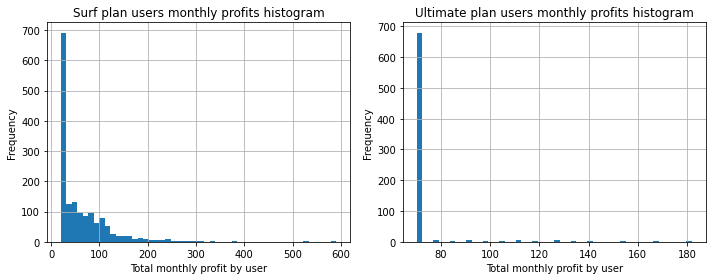

In [188]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
surf_profits.hist('total_profit', bins = 50, grid = True, ax = ax1)
ax1.set_xlabel('Total monthly profit by user')
ax1.set_ylabel('Frequency')
ax1.set_title('Surf plan users monthly profits histogram')

ultimate_profits.hist('total_profit', bins = 50, grid = True, ax = ax2)
ax2.set_xlabel('Total monthly profit by user')
ax2.set_ylabel('Frequency')
ax2.set_title('Ultimate plan users monthly profits histogram')

plt.tight_layout() 

For both plans, most of the time the users managed to keep their usage within or at least close to what the plans provide. However, more surf plan users than ultimate plan users seem to go beyond the plan. There are also some extreme surf user outliers who paid over 200. 

Let's have a look at the percentage of users from each plan who go over the plan. 

In [189]:
len(surf_profits.query('total_profit > 20')) / len(surf_profits)

0.7260012714558169

In [190]:
len(surf_profits.query('total_profit > 70')) / len(surf_profits)

0.31150667514303876

In [191]:
len(ultimate_profits.query('total_profit > 70')) / len(ultimate_profits)

0.05694444444444444

It needs to be noted that the percentage here is not user percentage because each user has multiple months in the dataset. So the percentage here is usage percentage. 

It's interesting to see more over 72% of the surf plan usage went beyond the plan, and 31% of the usage incur a fee that is more than 70. These users would be better off going with the ultimate plan. 

In contrast, only slightly over 5% of the ultimate went beyond the plan coverage. 

Next, for each plan, let's calculate the monthly call minutes, number of messages, internet by user, and the profits. The purpose of this calculation is to estimate how much of each service is needed by the users of each plan. Although each user's need could vary from month to month, here we want to obtain a general picture of how the users' need is distributed, therefore we will take the median usage across the months of each user. 

We will also calculate the median in total profits from each user which we will use when comparing the profits from two plans later. 

In [192]:
surf_usage = surf_profits.groupby('user_id')[[
    'total_minutes', 'total_messages', 'gb_used', 'total_profit']].median().reset_index()

In [193]:
ultimate_usage = ultimate_profits.groupby('user_id')[[
    'total_minutes', 'total_messages', 'gb_used', 'total_profit']].median().reset_index()

In [194]:
display(surf_usage)

,user_id,total_minutes,total_messages,gb_used,total_profit
0,1001,393.0,44.0,19.0,60.00
1,1002,384.0,32.0,15.0,20.00
2,1003,1104.0,50.0,27.0,158.12
3,1004,359.5,24.5,21.0,80.00
4,1005,496.0,11.0,17.0,40.00
...,...,...,...,...,...
328,1494,485.5,30.0,15.5,26.74
329,1495,426.5,0.0,24.5,115.00
330,1496,308.0,13.0,14.0,20.00
331,1498,288.0,0.0,20.0,70.00


In [195]:
display(ultimate_usage)

,user_id,total_minutes,total_messages,gb_used,total_profit
0,1000,124.0,11.0,2.0,70.0
1,1006,34.5,77.0,17.5,77.0
2,1008,476.0,26.0,17.0,70.0
3,1011,486.0,58.0,21.0,70.0
4,1013,219.0,16.0,20.0,70.0
...,...,...,...,...,...
152,1482,56.0,5.0,1.0,70.0
153,1487,416.0,66.0,14.0,70.0
154,1490,408.0,0.0,36.5,115.5
155,1493,473.0,0.0,15.0,70.0


While we are here, let's add user's age_group and city to both datasets as well for later use.

In [196]:
users_age_group = users_new[['user_id', 'age_group', 'city']]
users_age_group

,user_id,age_group,city
0,1000,45-54,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,18-34,"Seattle-Tacoma-Bellevue, WA MSA"
2,1002,35-44,"Las Vegas-Henderson-Paradise, NV MSA"
3,1003,45-54,"Tulsa, OK MSA"
4,1004,35-44,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...
495,1495,above 65,"New York-Newark-Jersey City, NY-NJ-PA MSA"
496,1496,45-54,"New Orleans-Metairie, LA MSA"
497,1497,45-54,"Los Angeles-Long Beach-Anaheim, CA MSA"
498,1498,45-54,"New York-Newark-Jersey City, NY-NJ-PA MSA"


In [197]:
surf_usage = surf_usage.merge(users_age_group, how = 'left', on = 'user_id')

In [198]:
ultimate_usage = ultimate_usage.merge(users_age_group, how = 'left', on = 'user_id')

We will also combine the two and create a total_usage dataset. Having the complete dataset and also the separate dataset by plan will be handy when we plot the data.

In [199]:
surf_usage['plan'] = "surf"
ultimate_usage['plan'] = 'ultimate'

In [200]:
total_usage = pd.concat([surf_usage, ultimate_usage]).reset_index(drop = True)

In [201]:
total_usage.head()

,user_id,total_minutes,total_messages,gb_used,total_profit,age_group,city,plan
0,1001,393.0,44.0,19.0,60.00,18-34,"Seattle-Tacoma-Bellevue, WA MSA",surf
1,1002,384.0,32.0,15.0,20.00,35-44,"Las Vegas-Henderson-Paradise, NV MSA",surf
2,1003,1104.0,50.0,27.0,158.12,45-54,"Tulsa, OK MSA",surf
3,1004,359.5,24.5,21.0,80.00,35-44,"Seattle-Tacoma-Bellevue, WA MSA",surf
4,1005,496.0,11.0,17.0,40.00,18-34,"Dallas-Fort Worth-Arlington, TX MSA",surf


**4.6 Plot the distribution of the monthly usage by user of the calling service**

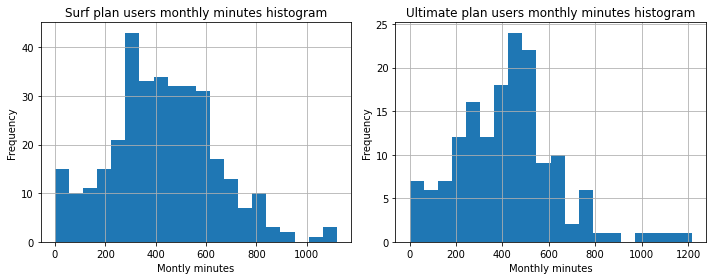

In [202]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
surf_usage['total_minutes'].plot(kind = 'hist', bins = 20, grid = True, ax = ax1)
ax1.set_xlabel('Montly minutes')
ax1.set_ylabel('Frequency')
ax1.set_title('Surf plan users monthly minutes histogram')

ultimate_usage['total_minutes'].plot(kind = 'hist', bins = 20, grid = True, ax = ax2)
ax2.set_xlabel('Monthly minutes')
ax2.set_ylabel('Frequency')
ax2.set_title('Ultimate plan users monthly minutes histogram')

plt.tight_layout() 

The above histograms show the for surf users, the minutes needed per month centre around 300 - 600 minutes, part of which goes over the 500 minutes allowed in the plan. 

Ultimate users show a similar pattern in their monthly calling minutes, however, given their plan caps at 3000, none went over the limit. 

As histograms are affected by the number of bins we assign, let's also take a look at the violin plots for the monthly minutes.

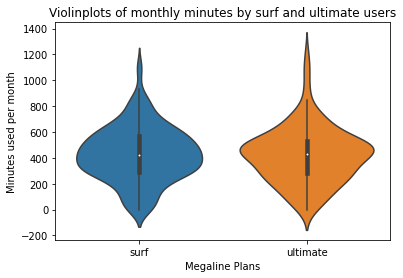

In [203]:
sns.violinplot(x = 'plan', y = 'total_minutes', data = total_usage)
plt.title("Violinplots of monthly minutes by surf and ultimate users")
plt.xlabel('Megaline Plans')
plt.ylabel('Minutes used per month')
plt.show()

In [204]:
surf_usage['total_minutes'].describe()

count     333.000000
mean      429.318318
std       211.127312
min         0.000000
25%       294.000000
50%       423.000000
75%       569.000000
max      1119.000000
Name: total_minutes, dtype: float64

In [205]:
ultimate_usage['total_minutes'].describe()

count     157.000000
mean      422.710191
std       215.652425
min         0.000000
25%       281.500000
50%       430.000000
75%       528.000000
max      1215.000000
Name: total_minutes, dtype: float64

Both the violin plots and the summary statistics above show that surf users and ultimate users exhibit a similar pattern in terms of how many calling minutes they've used, with the mean of approximately 429 and 422 minutes, median of 423 and 430 minutes, respectively. The dispersion of the minutes is also very similar. 

**4.7 Plot the monthly message usage**

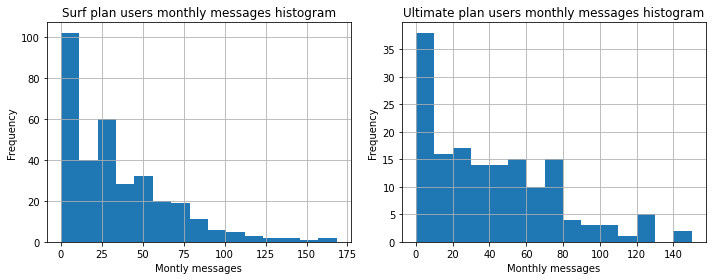

In [206]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
surf_usage['total_messages'].plot(kind = 'hist', bins = 15, grid = True, ax = ax1)
ax1.set_xlabel('Montly messages')
ax1.set_ylabel('Frequency')
ax1.set_title('Surf plan users monthly messages histogram')

ultimate_usage['total_messages'].plot(kind = 'hist', bins = 15, grid = True, ax = ax2)
ax2.set_xlabel('Monthly messages')
ax2.set_ylabel('Frequency')
ax2.set_title('Ultimate plan users monthly messages histogram')

plt.tight_layout() 

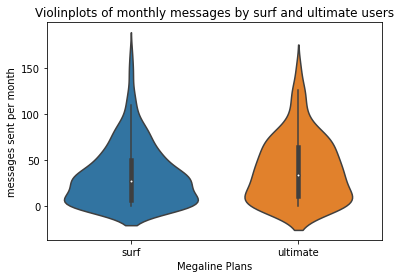

In [207]:
sns.violinplot(x = 'plan', y = 'total_messages', data = total_usage)
plt.title("Violinplots of monthly messages by surf and ultimate users")
plt.xlabel('Megaline Plans')
plt.ylabel('messages sent per month')
plt.show()

In [208]:
surf_usage['total_messages'].describe()

count    333.000000
mean      33.984985
std       32.704520
min        0.000000
25%        7.000000
50%       28.000000
75%       50.000000
max      168.500000
Name: total_messages, dtype: float64

In [209]:
ultimate_usage['total_messages'].describe()

count    157.000000
mean      40.353503
std       35.193661
min        0.000000
25%       11.000000
50%       34.000000
75%       64.000000
max      150.000000
Name: total_messages, dtype: float64

The plots and summary statistics show that users overall did pretty well in keeping the number of messages sent below the plan cap, which is 50 for surf users, and 1000 for ultimate users. 25% of the surf users went beyond the limit, whereas, given the high cap number, none of the ultimate users went beyond their plan. 

Users of both plan show similar patterns in their use of the messages function, with a mean approximately 33 and 40, and a median of 38 and 34 messages, for surf and ultimate users respectively. The dispersion of the number is also very similar across the two groups. 

**4.8 Plot the monthly internet usage**

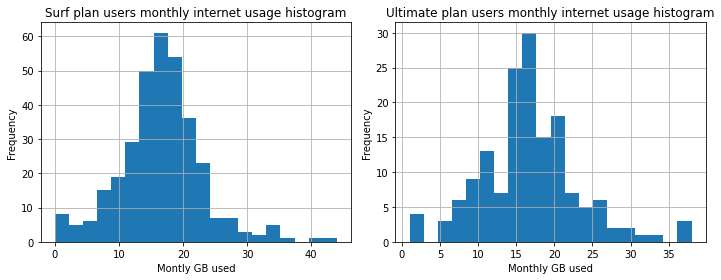

In [210]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
surf_usage['gb_used'].plot(kind = 'hist', bins = 20, grid = True, ax = ax1)
ax1.set_xlabel('Montly GB used')
ax1.set_ylabel('Frequency')
ax1.set_title('Surf plan users monthly internet usage histogram')

ultimate_usage['gb_used'].plot(kind = 'hist', bins = 20, grid = True, ax = ax2)
ax2.set_xlabel('Monthly GB used')
ax2.set_ylabel('Frequency')
ax2.set_title('Ultimate plan users monthly internet usage histogram')

plt.tight_layout() 

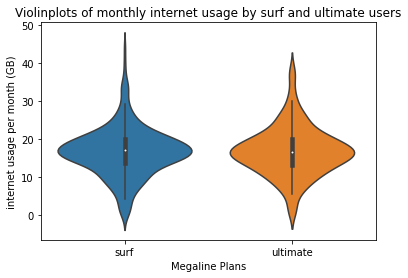

In [211]:
sns.violinplot(x = 'plan', y = 'gb_used', data = total_usage)
plt.title("Violinplots of monthly internet usage by surf and ultimate users")
plt.xlabel('Megaline Plans')
plt.ylabel('internet usage per month (GB)')
plt.show()

In [212]:
surf_usage['gb_used'].describe()

count    333.000000
mean      16.534535
std        6.403442
min        0.000000
25%       13.500000
50%       17.000000
75%       20.000000
max       44.000000
Name: gb_used, dtype: float64

In [213]:
ultimate_usage['gb_used'].describe()

count    157.000000
mean      16.732484
std        6.453365
min        1.000000
25%       13.000000
50%       16.500000
75%       20.000000
max       38.000000
Name: gb_used, dtype: float64

As seen from the plots and summary statistics, the distribution of the internet use is very similar across the two groups, with almost the same mean, median and standard deviation. 

However, given the plan cap for surf users is 15, and 30 for ultimate users, a lot more surf users than ultimate users went beyond their plan limit. 

Given the information above, we might suspect internet could be the biggest source of profits compared from other two services. So let's have a look. 

In [214]:
surf_profits.head()

,user_id,month,number_of_calls,total_minutes,calls_profit,total_messages,messages_profit,gb_used,internet_profit,total_profit
0,1001,8,22.0,182.0,0.0,30.0,0.00,7.0,0.0,20.00
1,1001,9,38.0,315.0,0.0,44.0,0.00,14.0,0.0,20.00
2,1001,10,47.0,393.0,0.0,53.0,0.09,22.0,70.0,90.09
3,1001,11,49.0,426.0,0.0,36.0,0.00,19.0,40.0,60.00
4,1001,12,46.0,412.0,0.0,44.0,0.00,19.0,40.0,60.00


In [215]:
print('Surf plan profits from calls:', surf_profits['calls_profit'].sum())
print('Surf plan profits from messages:', surf_profits['messages_profit'].sum())
print('Surf plan profits from internet:', surf_profits['internet_profit'].sum())

print('Percentage of internet profit for the Ultimate plan:', 
      surf_profits['internet_profit'].sum() / surf_profits['total_profit'].sum())

print('Ultimate plan profits from calls:', ultimate_profits['calls_profit'].sum())
print('Ultimate plan profits from messages:', ultimate_profits['messages_profit'].sum())
print('Ultimate plan profits from internet:', ultimate_profits['internet_profit'].sum())

print('Percentage of internet profit for the Ultimate plan:', 
      ultimate_profits['internet_profit'].sum() / ultimate_profits['total_profit'].sum())

Surf plan profits from calls: 2900.25
Surf plan profits from messages: 330.92999999999995
Surf plan profits from internet: 60800.0
Percentage of internet profit for the Ultimate plan: 0.6367080184787748
Ultimate plan profits from calls: 0.0
Ultimate plan profits from messages: 0.0
Ultimate plan profits from internet: 1666.0
Percentage of internet profit for the Ultimate plan: 0.03199784888410863


Yes indeed! The additional profits from the internet is as high as 60610, which represents over 60% of the plan profits. 

The additional profits for the ultimate plan comes entirely from the internet usage. Given the plan fee is high itself, the additional internet profits represens approximately 3% of the total profits. 

**4.9 Age group and usage**

It would also be interesting to see how different age groups might use the services differently and contribute to the total profits. Let's make some plots to show that. 

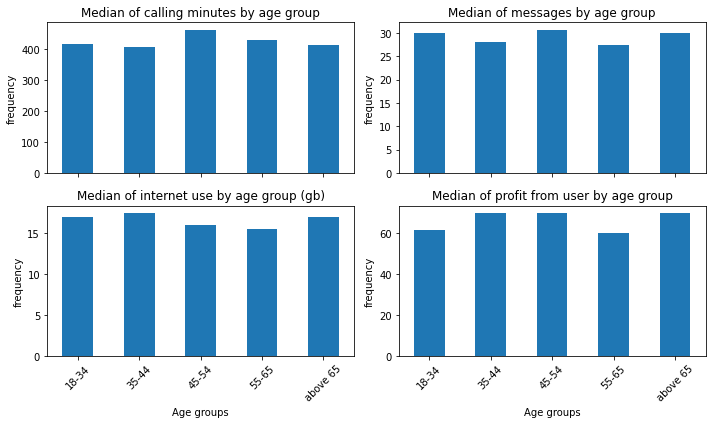

In [216]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,6), sharex = True)
total_usage.groupby('age_group')['total_minutes'].median().plot(kind = 'bar', ax = ax1)
ax1.set_title('Median of calling minutes by age group')
ax1.set_ylabel('frequency')

total_usage.groupby('age_group')['total_messages'].median().plot(kind = 'bar', ax = ax2)
ax2.set_title('Median of messages by age group')
ax2.set_ylabel('frequency')

total_usage.groupby('age_group')['gb_used'].median().plot(kind = 'bar', ax = ax3)
ax3.set_title('Median of internet use by age group (gb)')
ax3.set_ylabel('frequency')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation= 45)
ax3.set_xlabel('Age groups')

total_usage.groupby('age_group')['total_profit'].median().plot(kind = 'bar', ax = ax4)
ax4.set_title('Median of profit from user by age group')
ax4.set_ylabel('frequency')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation= 45)
ax4.set_xlabel('Age groups')

plt.tight_layout() 

In [217]:
total_usage.groupby('age_group')['total_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
18-34,159.0,428.273585,219.949007,0.0,300.00,416.00,545.75,1102.0
35-44,73.0,399.417808,181.398254,0.0,290.50,408.00,509.50,860.0
45-54,92.0,446.565217,209.067766,0.0,297.75,462.75,566.00,1111.0
55-65,87.0,442.793103,226.864748,0.0,293.00,427.50,577.50,1215.0
above 65,79.0,410.993671,212.097877,0.0,270.25,414.00,543.50,905.0


In [218]:
total_usage.groupby('age_group')['total_messages'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
18-34,159.0,35.207547,31.315478,0.0,9.50,30.00,54.0,150.0
35-44,73.0,34.315068,36.539696,0.0,0.50,28.00,53.0,168.5
45-54,92.0,36.402174,34.231696,0.0,11.00,30.75,49.0,159.0
55-65,87.0,33.867816,31.720844,0.0,7.75,27.50,56.5,128.0
above 65,79.0,41.189873,36.787967,0.0,12.25,30.00,69.0,148.0


In [219]:
total_usage.groupby('age_group')['gb_used'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
18-34,159.0,16.660377,6.558481,1.0,14.0,17.0,20.00,44.0
35-44,73.0,17.568493,7.133311,2.0,13.0,17.5,20.50,40.0
45-54,92.0,15.657609,5.548948,0.0,12.5,16.0,19.00,30.0
55-65,87.0,15.982759,6.911588,1.0,12.0,15.5,19.25,37.0
above 65,79.0,17.348101,5.679673,1.0,15.0,17.0,20.25,34.0


In [220]:
total_usage.groupby('age_group')['total_profit'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
18-34,159.0,62.009182,42.920772,20.0,30.0000,61.74,70.0,320.185
35-44,73.0,63.267055,43.476760,20.0,30.0500,70.00,70.0,270.000
45-54,92.0,58.372826,28.603989,20.0,37.0125,70.00,70.0,158.120
55-65,87.0,57.156839,40.131956,20.0,23.4800,60.00,70.0,243.390
above 65,79.0,66.717975,37.655906,20.0,40.0000,70.00,70.0,219.315


The median plots for calling minutes, messages, internet use and total profits show very similar figures across all 5 age groups. 

Taking a look at the summary statistics, we could notice that users in the 45-54 age group have a slightly higher median calling minutes than the others, users below the age of 45, and above 65 have slightly higher internet usage than the others. 

While the differences seem to be small, whether these are significant or not will need to be tested. For the purpose of this analysis, we will not go further along this line. 

### Part 4 summary 

In this section, we took a look at the monthly usage of each of the three services by plan, as well as the monthly profits. It is really interesting to see that, despite which calling plan the users have, they seem to have very similar need for calling, messaging, and internet use services. Therefore, because the surf plan has a lower cap on all three, users of the surf plan tend to use beyond the plan, especially when it comes to internet use. 

Such information is important to the commercial department because, if they want to promote the Ultimate calling plan, they can choose to target those who tend to go over the plan, especaily those surf plan users who actually have paid more than the ultimate plan. Having said that, profit wise, if these users keep paying like that, it might be more profitable to keep them as surf users. 

### Part 5: Hypothesis testing

<a id="hypothesis"></a>

In this section, we will test the following hypotheses: 

 - The average profit from users of Ultimate and Surf calling plans differs; 
 - The average profit from users in NY-NJ area is different from that of the users from other regions.
 
Both tests will be two sided, and the alpha value for the hypothesis testing will be 0.05. 

**5.1 Hypothesis test 1**

The null hypothesis for this test is: the average profit from Ultimate and Surf calling plan users are the same; and the alternative hypothesis is they are different. 

We will first have a look at the summary statistics of the total_profit of two plans, and then conduct a t test to compare the means. 

In [221]:
surf_usage['total_profit'].describe()

count    333.000000
mean      56.636997
std       46.676055
min       20.000000
25%       21.260000
50%       42.400000
75%       73.780000
max      320.185000
Name: total_profit, dtype: float64

In [222]:
ultimate_usage['total_profit'].describe()

count    157.000000
mean      71.538217
std        7.459837
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      126.000000
Name: total_profit, dtype: float64

The information above shows that the two plans have quite different dispersion. We will set equal_var as False for the t test. 

In [223]:
st.ttest_ind(surf_usage['total_profit'], ultimate_usage['total_profit'], 
             equal_var = False).pvalue

2.8350507625849942e-08

The pvalue we get from the test is a lot smaller than alpha, 0.05. Therefore we reject the null hypthesis, and have reason to believe that the profit from the two plans are different. 

If we are to run a one sided hypothesis test using the same alpha 0.05 to test if the average profit from ultimate plan is higher than the surf plan, the pvalue will be halved, and it is still smaller than alpha. 

Therefore based on the test above, we can conclude that, on average, Megaline generate more profits from its ultimate plan than the surf plan. 

**5.2 Hypothesis testing 2**

In [224]:
total_usage['city'].value_counts()

New York-Newark-Jersey City, NY-NJ-PA MSA          79
Los Angeles-Long Beach-Anaheim, CA MSA             29
Dallas-Fort Worth-Arlington, TX MSA                20
Chicago-Naperville-Elgin, IL-IN-WI MSA             19
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA    17
                                                   ..
Colorado Springs, CO MSA                            1
Cape Coral-Fort Myers, FL MSA                       1
Jacksonville, FL MSA                                1
Raleigh-Cary, NC MSA                                1
Albany-Schenectady-Troy, NY MSA                     1
Name: city, Length: 73, dtype: int64

There are a total of 79 users from NY-NJ area. The null hypothesis for this test is that the average profits from these users and those from others do not differ. The alternative hypothesis is that they are different. 

First let's separate the dataset by regions and take a look at the summary statistics of total profit. 

In [225]:
total_usage_ny = total_usage.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')

In [226]:
total_usage_other = total_usage.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')

In [227]:
total_usage_ny['total_profit'].describe()

count     79.000000
mean      56.882975
std       37.000064
min       20.000000
25%       25.800000
50%       51.920000
75%       70.000000
max      210.290000
Name: total_profit, dtype: float64

In [228]:
total_usage_other['total_profit'].describe()

count    411.000000
mean      62.281910
std       39.723804
min       20.000000
25%       30.120000
50%       70.000000
75%       70.000000
max      320.185000
Name: total_profit, dtype: float64

The above shows that the two groups have similar variance. We will use the default equal_var setting for the t test below.

In [229]:
st.ttest_ind(total_usage_ny['total_profit'], 
             total_usage_other['total_profit']).pvalue

0.26400973729852173

Using alpha 0.05, the pvalue we get from the test above is higher than the alpha value. Therefore we fail to reject the null hypothesis and can not say that the average profits from users in NY-NJ region and from users in other regions are different. 

**5.3 Current users v.s previous users.** 

Finally, as an extra research, I'm interested in finding out how the users who terminated their plan might different from the others. Let's just take a quick look. 

In [230]:
total_usage_previous_user = total_usage[
    total_usage['user_id'].isin(users_previous["user_id"])]

In [231]:
total_usage_current_user = total_usage[
    ~total_usage['user_id'].isin(users_previous["user_id"])]

In [232]:
total_usage_previous_user['total_profit'].describe()

count     32.000000
mean      59.025000
std       29.786034
min       20.000000
25%       36.250000
50%       65.870000
75%       70.000000
max      124.710000
Name: total_profit, dtype: float64

In [233]:
total_usage_current_user['total_profit'].describe()

count    458.000000
mean      61.578210
std       39.912033
min       20.000000
25%       30.000000
50%       70.000000
75%       70.000000
max      320.185000
Name: total_profit, dtype: float64

Although the statistics above is quite telling already, let's still do a quick t test with the null hypothesis that the average profits from the two groups, previous and current users, are the same. Alpha value will be the same, 0.05.

In [234]:
st.ttest_ind(total_usage_previous_user['total_profit'],
             total_usage_current_user['total_profit'], equal_var = False).pvalue

0.6501398236846614

That's a very large p value, so we can't reject the null hypothesis. Therefore probably the users didn't terminate the plan because they think they have been ripped off by Megaline, because they are paying about the same as the current users. This is just a side track analysis out of interest. Megaline probably have other ways to find out why users terminate the plan, such as a survey or etc. 

### Part 5 summary

Among the three hypotheses in this section, we successfully rejected the first one, based on which we can conclude that the average profits differs by plan, the ultimate plan is more profitable than the surf plan. 

### Part 6: Findings and conclusions 

<a id="conclusion"></a>

In this report, we've analyzed the calling plan usage of 500 Megaline clients. A close look at the clients' usage of all three services, and the profits generated from each plan, tells us that, despite the two plans differing greatly in their cap on calling minutes, messages, and internet use, the users of the two plans show similar patterns in how much service they consume. This results in majority of the monthly payment by the surf plan clients going beyond the basic plan cost. 

Given the ultimate plan on average brings more profit to the company than the surf plan, it would be a win-win situation for both if Megaline promotes its ultimate package, especially to those surf users who incur more cost even than the ultimate plan charge. 

Moreoever, it is a big jump from 20 to 70 between the two plans. Given the results of the analysis of the users' behaviors, it might be a good idea to have a third plan which includes, for example, 800 minutes calls, and 20GB internet, at a price, for example, 50 dollars. Based on our analysis, there are a lot of users who actually need this much service but for whom what the ultimate plan offers might feel a little over the top. Having a intermediate level plan will allow the company to more easily peruade them to upgrade and gain more profits. A possible name for it is the Cruise plan:) 